In [1]:
import sys
import os
sys.path.append('..')
from lib.path import get_training_data_dir, get_predicted_labeled_water_path, get_displaceable_water_path, get_non_displaceable_water_path
from lib.pdb import filter_atoms_and_create_new_pdb
from data_loader.SingleDataLoader import SingleDataLoader
from data_loader.DoubleDataLoader import DoubleDataLoader
from models.LeNet import LeNet
from models.ResNet import ResNet
from models.ResNet_revised import ResNet_revised
from lib.helper import get_latest_checkpoint
from tensorflow.keras.losses import BinaryCrossentropy
from custom_losses.dice import dice_loss, dice_coefficient
from tensorflow.keras.metrics import Recall, Precision, Accuracy, SpecificityAtSensitivity, AUC, F1Score
from sklearn.metrics import fbeta_score, confusion_matrix
import numpy as np
from lib.plot import plot_histogram

2024-12-22 20:02:41.075950: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-22 20:02:41.090081: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-22 20:02:41.104492: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-22 20:02:41.108757: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-22 20:02:41.120118: I tensorflow/core/platform/cpu_feature_guar

In [2]:
import tensorflow as tf

# GPUを無効化
tf.config.set_visible_devices([], 'GPU')

In [3]:
DATA_TYPE1 = 'gr'
DATA_VOXEL_NUM = 20
CLASSIFYING_RULE = 'WaterClassifyingRuleEmbedding'
LIGAND_POCKET_DEFINER = 'LigandPocketDefinerOriginal'
LIGAND_VOXEL_NUM = 8
MODEL_NAME = 'ResNet'
TRAINER_NAME = 'aug_train'
training_data_dir1 = get_training_data_dir(DATA_TYPE1, DATA_VOXEL_NUM, CLASSIFYING_RULE, LIGAND_POCKET_DEFINER, LIGAND_VOXEL_NUM)
data_loader = SingleDataLoader(training_data_dir1)

In [12]:
input_shape = (DATA_VOXEL_NUM*2+1, DATA_VOXEL_NUM*2+1, DATA_VOXEL_NUM*2+1, 1)
n_base = 8
BN = True
checkpoint_dir = f'../checkpoints/valid_all/smoothing/{DATA_TYPE1}/data_voxel_num_{DATA_VOXEL_NUM}/{LIGAND_POCKET_DEFINER}/ligand_pocket_voxel_num_{LIGAND_VOXEL_NUM}/{CLASSIFYING_RULE}/{MODEL_NAME}/{TRAINER_NAME}/'
latest_checkpoint = get_latest_checkpoint(checkpoint_dir)
model = ResNet(n_base=n_base, input_shape=input_shape, learning_rate=0.0, loss=BinaryCrossentropy(), metrics=[], BN=BN, class_num=2)
model.load_weights(latest_checkpoint)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 41, 41,    │          0 │ -                 │
│ (InputLayer)        │ 41, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_18 (Conv3D)  │ (None, 41, 41,    │        224 │ input_layer_2[0]… │
│                     │ 41, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 41, 41,    │         32 │ conv3d_18[0][0]   │
│ (BatchNormalizatio… │ 41, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_14       │ (None, 41, 41,    │          0 │ batch_normalizat… │
│ (Activation)        │ 41, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_19 (Conv3D)  │ (None, 41, 41,    │      1,736 │ activation_14[0]… │
│                     │ 41, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 41, 41,    │         32 │ conv3d_19[0][0]   │
│ (BatchNormalizatio… │ 41, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_15       │ (None, 41, 41,    │          0 │ batch_normalizat… │
│ (Activation)        │ 41, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_20 (Conv3D)  │ (None, 41, 41,    │      1,736 │ activation_15[0]… │
│                     │ 41, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 41, 41,    │         32 │ conv3d_20[0][0]   │
│ (BatchNormalizatio… │ 41, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 41, 41,    │          0 │ batch_normalizat… │
│                     │ 41, 8)            │            │ activation_14[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 41, 41,    │          0 │ add_6[0][0]       │
│ (Activation)        │ 41, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_6     │ (None, 20, 20,    │          0 │ activation_16[0]… │
│ (MaxPooling3D)      │ 20, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_21 (Conv3D)  │ (None, 20, 20,    │      3,472 │ max_pooling3d_6[… │
│                     │ 20, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20, 20,    │         64 │ conv3d_21[0][0]   │
│ (BatchNormalizatio… │ 20, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 20, 20,    │          0 │ batch_normalizat… │
│ (Activation)        │ 20, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_22 (Conv3D)  │ (None, 20, 20,    │      6,928 │ activation_17[0]… │
│                     │ 20, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_23 (Conv3D)  │ (None, 20, 20,    │        144 │ max_pooling3d_6[

 Total params: 58,114 (227.01 KB)

 Trainable params: 57,778 (225.70 KB)

 Non-trainable params: 336 (1.31 KB)

In [11]:
def custom_threshold(prediction, threshold):
    return (prediction > threshold).astype(int)
threshold = 0.5

In [27]:
data_dir = '../../data'
test_list = os.path.join(data_dir, 'all_valid_test.txt')
with open(test_list, 'r') as f:
    test_pdb_array = f.read().splitlines()
cm_for_each_pdb = {}
accuracy_for_each_pdb = {}
recall_for_each_pdb = {}
precision_for_each_pdb = {}
specificity_for_each_pdb = {}
negative_precision_for_each_pdb = {}

for pdb in test_pdb_array[:100]:
    print(pdb)
    test_data, test_data_label = data_loader.load_data_with_pdb_array([pdb])
    prediction = model.predict(test_data)
    predicted_label = (prediction[:, 1] >= threshold).astype(int)
    cm1 = confusion_matrix(test_data_label, predicted_label)
    cm_for_each_pdb[pdb] = cm1

    # Recall (Sensitivity, True Positive Rate)
    recall_for_each_pdb[pdb] = cm1[1, 1] / (cm1[1, 1] + cm1[1, 0]) if (cm1[1, 1] + cm1[1, 0]) != 0 else 0

    # Precision (Positive Predictive Value)
    precision_for_each_pdb[pdb] = cm1[1, 1] / (cm1[1, 1] + cm1[0, 1]) if (cm1[1, 1] + cm1[0, 1]) != 0 else 0

    # Negative Predictive Value (NPV)
    negative_precision_for_each_pdb[pdb] = cm1[0, 0] / (cm1[0, 0] + cm1[1, 0]) if (cm1[0, 0] + cm1[1, 0]) != 0 else 0

    # Accuracy
    accuracy_for_each_pdb[pdb] = (cm1[0, 0] + cm1[1, 1]) / np.sum(cm1) if np.sum(cm1) != 0 else 0

    # Specificity (True Negative Rate)
    specificity_for_each_pdb[pdb] = cm1[0, 0] / (cm1[0, 0] + cm1[0, 1]) if (cm1[0, 0] + cm1[0, 1]) != 0 else 0


4l23
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step 
4waf
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step 
4jps
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step 
3ddg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
3dx1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
3dx2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
3dx3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
3dx4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1ps3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
3ejp
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
3ejq
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
3ejr
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
3ddf
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
3d4y
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
3d4z
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
3d50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
3d51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
3d52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
2f7o
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
2f7p
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
4fys
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
3l4u
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
3l4v
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms

In [28]:
accuracy_for_each_pdb_np = np.array(list(accuracy_for_each_pdb.values()))
recall_for_each_pdb_np = np.array(list(recall_for_each_pdb.values()))
precision_for_each_pdb_np = np.array(list(precision_for_each_pdb.values()))
specificity_for_each_pdb_np = np.array(list(specificity_for_each_pdb.values()))
negative_precision_for_each_pdb_np = np.array(list(negative_precision_for_each_pdb.values()))

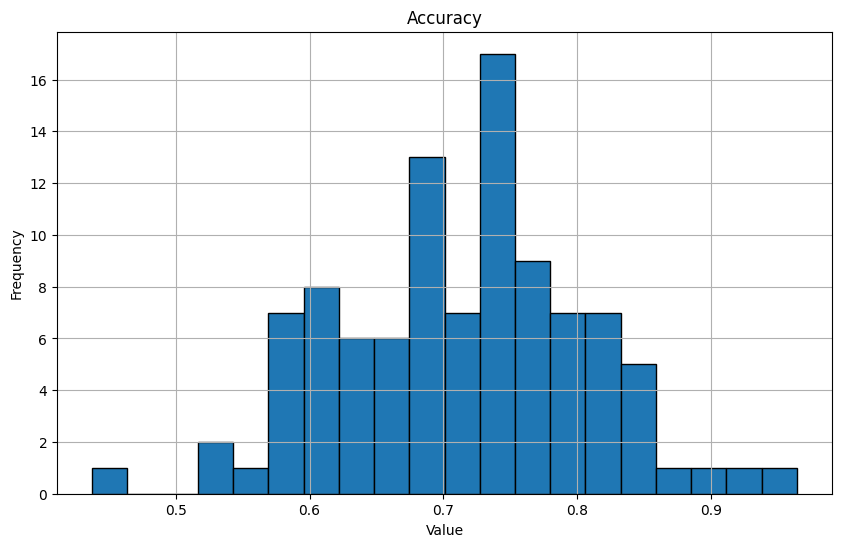

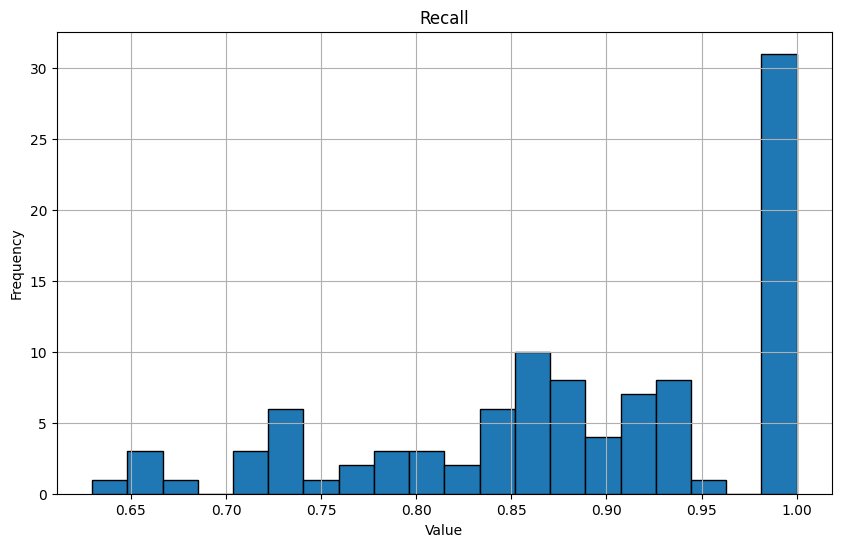

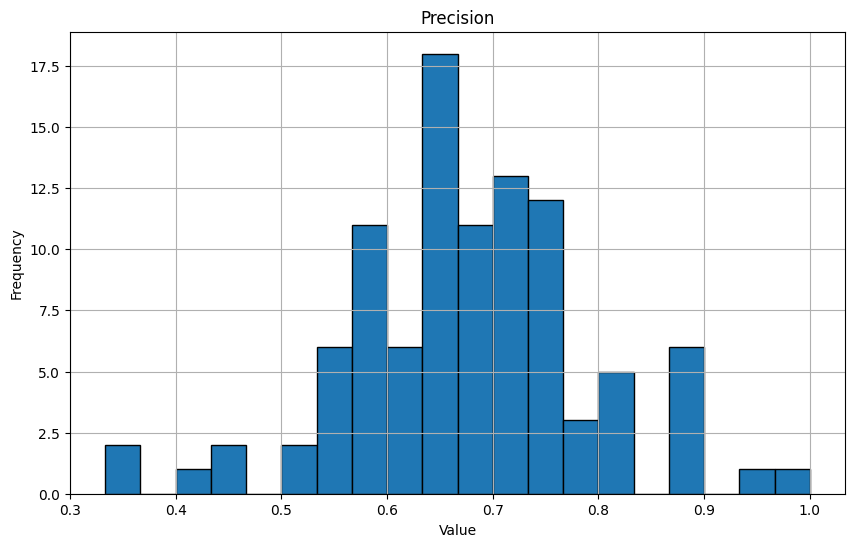

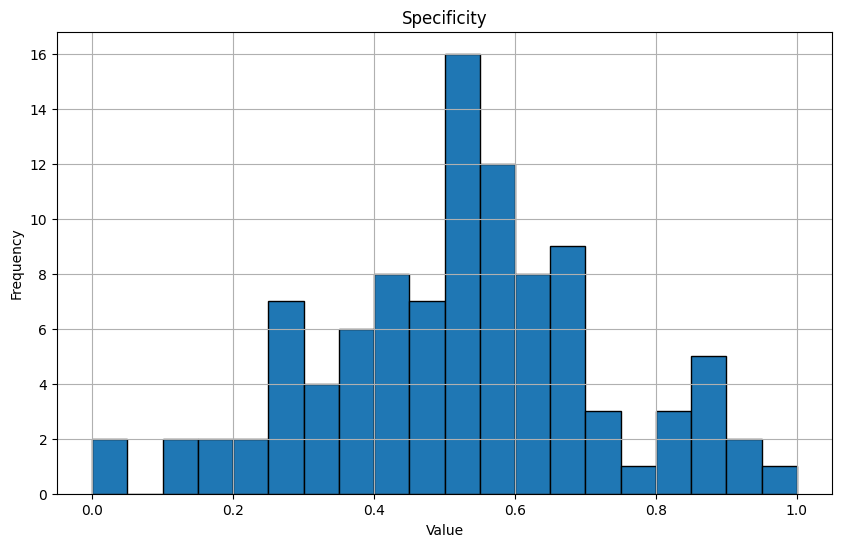

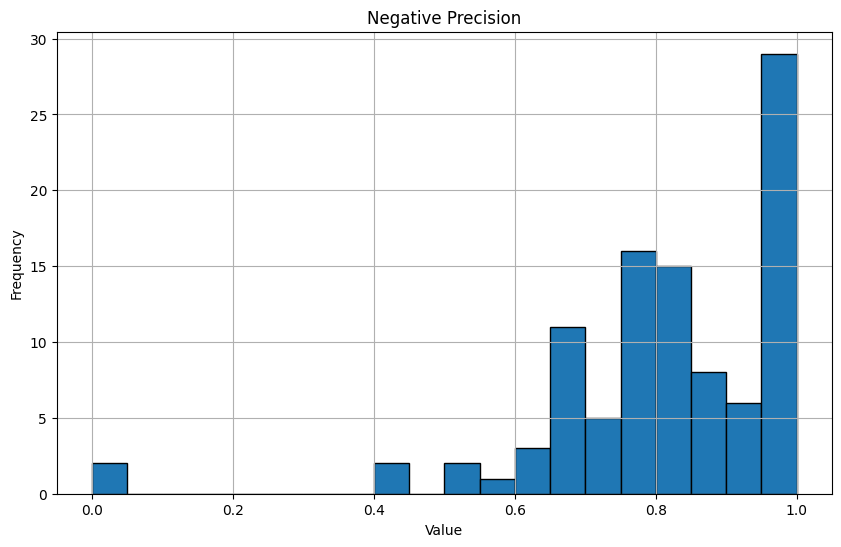

In [29]:
plot_histogram(accuracy_for_each_pdb_np, bins=20, title='Accuracy')
plot_histogram(recall_for_each_pdb_np, bins=20, title='Recall')
plot_histogram(precision_for_each_pdb_np, bins=20, title='Precision')
plot_histogram(specificity_for_each_pdb_np, bins=20, title='Specificity')
plot_histogram(negative_precision_for_each_pdb_np, bins=20, title='Negative Precision')

In [31]:
i = 3
under_threshold = 0.95
threshold = 1.1

accuracy_under_threshold = accuracy_for_each_pdb_np[(accuracy_for_each_pdb_np >= under_threshold) & (accuracy_for_each_pdb_np < threshold)]
indices = np.where((accuracy_for_each_pdb_np >= under_threshold) & (accuracy_for_each_pdb_np < threshold))[0]
print(np.array(test_pdb_array)[indices])
pdb = test_pdb_array[indices[i]]
print(accuracy_under_threshold)
print(cm_for_each_pdb[pdb])

['2wxl']


IndexError: index 3 is out of bounds for axis 0 with size 1

In [26]:
i = 5
under_threshold = 0.4
threshold = 0.5

recall_under_threshold = recall_for_each_pdb_np[(recall_for_each_pdb_np >= under_threshold) & (recall_for_each_pdb_np < threshold)]
indices = np.where((recall_for_each_pdb_np >= under_threshold) & (recall_for_each_pdb_np < threshold))[0]
print(np.array(test_pdb_array)[indices])
pdb = test_pdb_array[indices[i]]
print(recall_under_threshold)
print(cm_for_each_pdb[pdb])

[]


IndexError: index 5 is out of bounds for axis 0 with size 0

In [10]:
i = 0
threshold = 0.4

specificity_under_threshold = specificity_for_each_pdb_np[specificity_for_each_pdb_np < threshold]
indices = np.where((specificity_for_each_pdb_np < threshold))[0]
print(np.array(test_pdb_array)[indices])
pdb = test_pdb_array[indices[i]]
print(specificity_under_threshold)
print(cm_for_each_pdb[pdb])

['1adl' '1hms' '1qkt' '1tnh' '1v2u' '2vl4' '2vmf' '2vot' '2vqt' '2xib'
 '3hmp' '3tzm' '4mss' '4pb2' '4y3j' '4y3y']
[0.38461538 0.33333333 0.33333333 0.33333333 0.25       0.2
 0.25       0.11111111 0.375      0.14285714 0.23529412 0.30769231
 0.28571429 0.23076923 0.33333333 0.33333333]
[[ 5  8]
 [ 1 16]]


In [1]:
import shutil

# コピー元のファイルパス
pdb = '4pb2'
source_file1 = f'/mnt/dandan/3drism/dir_3DRISM_20181213_155211/{pdb}/{pdb}_min.pdb'
source_file2 = f'/mnt/dandan/3drism/dir_3DRISM_20181213_155211/{pdb}/{pdb}_ligand.pdb'

# コピー先のディレクトリ
destination_directory = '/home/ito/research/'

# ファイルをコピー
shutil.copy(source_file1, destination_directory)
shutil.copy(source_file2, destination_directory)

print("ファイルのコピーが完了しました。")


ファイルのコピーが完了しました。
